In [1]:
# Importação de bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from imblearn.over_sampling import SMOTE
from collections import Counter

<a href="https://colab.research.google.com/github/fggrava/Challenge_ONE_Data_Science_TelecomX-_2---Prevendo-Churn/blob/main/Challenge_ONE_Data_Science_TelecomX__2_Prevendo_Churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Carregamento dos dados
df = pd.read_csv('/content/TelecomX 2.csv')

# Etapa 1: Limpeza e preparação inicial
def preprocess_data(df):
    df = df.copy()

    # Remover colunas irrelevantes
    df.drop(columns=['customerID'], inplace=True, errors='ignore')

    # Remover espaços em branco
    df.columns = df.columns.str.strip()

    # Tratar valores nulos
    df.replace(" ", np.nan, inplace=True)
    df.dropna(inplace=True)

    # Converter colunas numéricas
    for col in df.columns:
        try:
            df[col] = pd.to_numeric(df[col])
        except:
            pass

    return df

df = preprocess_data(df)

In [3]:
# Etapa 2: Codificação de variáveis categóricas
def encode_categoricals(df):
    df = df.copy()
    cat_cols = df.select_dtypes(include='object').columns.tolist()

    # One-Hot Encoding
    df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

    return df

df_encoded = encode_categoricals(df)

In [4]:
# Etapa 3: Separação de variáveis
X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']

# Etapa 4: Normalização
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [5]:
#  Etapa 5: Seleção de variáveis
selector = SelectKBest(score_func=f_classif, k=10)
X_selected = selector.fit_transform(X_scaled, y)
selected_features = X.columns[selector.get_support()].tolist()

print("Variáveis mais relevantes:", selected_features)

Variáveis mais relevantes: ['customer_tenure', 'account_Charges_Monthly', 'account_Charges_Total', 'Contas_Diarias', 'internet_InternetService_Fiber optic', 'internet_InternetService_No', 'account_Contract_One year', 'account_Contract_Two year', 'account_PaperlessBilling_Yes', 'account_PaymentMethod_Electronic check']


In [22]:
# Proporção de clientes que evadiram vs. permaneceram
churn_counts = y.value_counts()
churn_ratio = churn_counts / len(y)

print("\nProporção de Classes:")
print(f"- Clientes Ativos (0): {churn_counts[0]} ({churn_ratio[0]:.2%})")
print(f"- Clientes Evasivos (1): {churn_counts[1]} ({churn_ratio[1]:.2%})")

# Avaliação de desequilíbrio
imbalance_threshold = 0.30  # Ajustável conforme o contexto
if churn_ratio.min() < imbalance_threshold:
    print("\n Desequilíbrio detectado entre as classes!")
    print("Isso pode impactar a performance dos modelos, especialmente na detecção de clientes evasivos.")
    print("Considere aplicar técnicas de balanceamento como:")
    print("- SMOTE (Synthetic Minority Oversampling Technique)")
    print("- Undersampling da classe majoritária")
    print("- Ajuste de pesos nos algoritmos")
else:
    print("\nAs classes estão relativamente balanceadas.")


Proporção de Classes:
- Clientes Ativos (0): 5387 (74.24%)
- Clientes Evasivos (1): 1869 (25.76%)

 Desequilíbrio detectado entre as classes!
Isso pode impactar a performance dos modelos, especialmente na detecção de clientes evasivos.
Considere aplicar técnicas de balanceamento como:
- SMOTE (Synthetic Minority Oversampling Technique)
- Undersampling da classe majoritária
- Ajuste de pesos nos algoritmos


/tmp/ipython-input-109284685.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"- Clientes Ativos (0): {churn_counts[0]} ({churn_ratio[0]:.2%})")
/tmp/ipython-input-109284685.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"- Clientes Evasivos (1): {churn_counts[1]} ({churn_ratio[1]:.2%})")



Proporção de Classes:
- Clientes Ativos (0): 5387 (74.24%)
- Clientes Evasivos (1): 1869 (25.76%)


/tmp/ipython-input-2335606541.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"- Clientes Ativos (0): {churn_counts[0]} ({churn_ratio[0]:.2%})")
/tmp/ipython-input-2335606541.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"- Clientes Evasivos (1): {churn_counts[1]} ({churn_ratio[1]:.2%})")


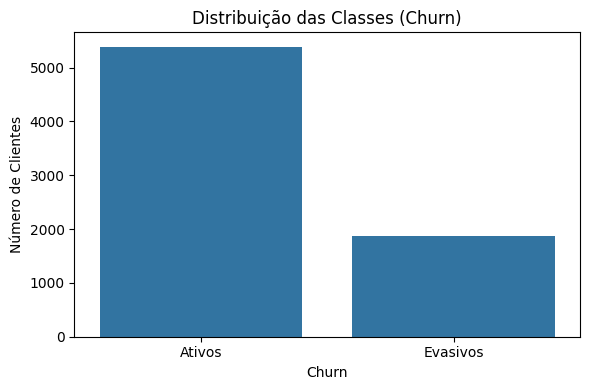


 Aplicando SMOTE para balancear as classes...
 Classes após SMOTE: Counter({False: 3757, True: 3757})

 Logistic Regression (SMOTE)
              precision    recall  f1-score   support

       False       0.91      0.72      0.81      1630
        True       0.49      0.79      0.61       547

    accuracy                           0.74      2177
   macro avg       0.70      0.76      0.71      2177
weighted avg       0.81      0.74      0.76      2177

ROC AUC: 0.8391387490046096

 Random Forest (SMOTE)
              precision    recall  f1-score   support

       False       0.85      0.85      0.85      1630
        True       0.55      0.55      0.55       547

    accuracy                           0.77      2177
   macro avg       0.70      0.70      0.70      2177
weighted avg       0.77      0.77      0.77      2177

ROC AUC: 0.8161045748701787


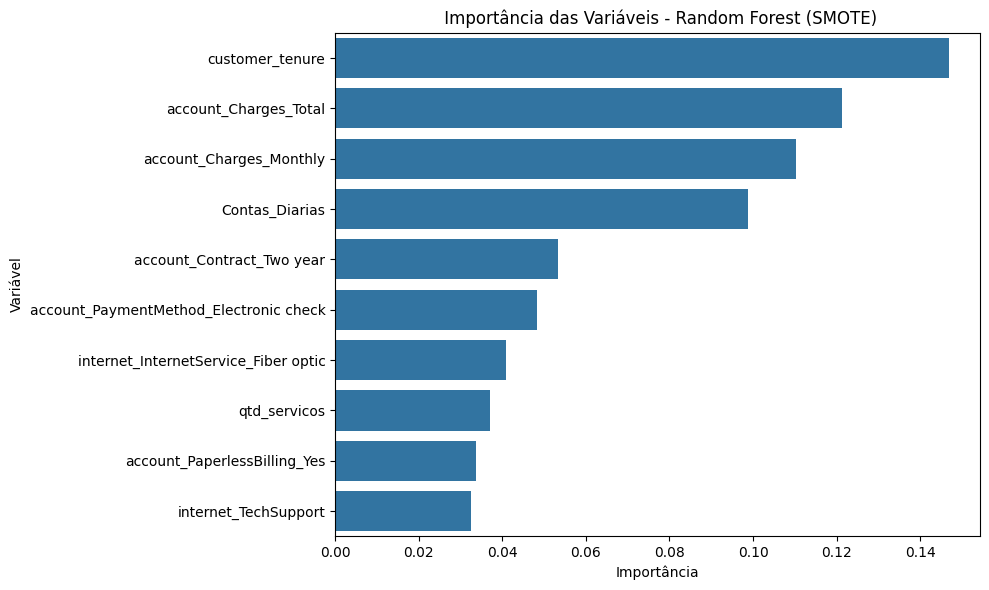

In [23]:
# Proporção de classes
churn_counts = y.value_counts()
churn_ratio = churn_counts / len(y)

print("\nProporção de Classes:")
print(f"- Clientes Ativos (0): {churn_counts[0]} ({churn_ratio[0]:.2%})")
print(f"- Clientes Evasivos (1): {churn_counts[1]} ({churn_ratio[1]:.2%})")

# Visualização do desequilíbrio
plt.figure(figsize=(6, 4))
sns.countplot(x=y)
plt.title("Distribuição das Classes (Churn)")
plt.xlabel("Churn")
plt.ylabel("Número de Clientes")
plt.xticks([0, 1], ['Ativos', 'Evasivos'])
plt.tight_layout()
plt.show()

# Divisão dos dados antes do balanceamento
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

#  Aplicação do SMOTE
print("\n Aplicando SMOTE para balancear as classes...")
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

print(" Classes após SMOTE:", Counter(y_train_bal))

#  Treinamento com dados balanceados
models = {
    'Logistic Regression (SMOTE)': LogisticRegression(max_iter=1000),
    'Random Forest (SMOTE)': RandomForestClassifier(n_estimators=100, random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train_bal, y_train_bal)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print(f"\n {name}")
    print(classification_report(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, y_proba))

    results[name] = {
        'model': model,
        'roc_auc': roc_auc_score(y_test, y_proba)
    }

# Importância das variáveis (Random Forest com SMOTE)
rf_model = results['Random Forest (SMOTE)']['model']
importances = pd.Series(rf_model.feature_importances_, index=X.columns)
top_importances = importances.sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_importances.values, y=top_importances.index)
plt.title(" Importância das Variáveis - Random Forest (SMOTE)")
plt.xlabel("Importância")
plt.ylabel("Variável")
plt.tight_layout()
plt.show()

In [8]:
# Padronização dos dados com StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Criação do DataFrame df2 com dados padronizados
df2 = pd.DataFrame(X_scaled, columns=X.columns)

# Adiciona a variável alvo 'Churn' ao df2
df2['Churn'] = y.values

# Visualização inicial do df2
print("\n DataFrame df2 - Dados Padronizados:")
print(df2.head())
print(df2.describe())



 DataFrame df2 - Dados Padronizados:
   customer_SeniorCitizen  customer_tenure  phone_MultipleLines  \
0               -0.441135        -0.952728            -0.854212   
1               -0.441135        -0.952728             1.170670   
2               -0.441135        -1.156341            -0.854212   
3                2.266881        -0.789837            -0.854212   
4                2.266881        -1.197063            -0.854212   

   internet_OnlineSecurity  internet_OnlineBackup  internet_DeviceProtection  \
0                -0.632639               1.379275                  -0.722145   
1                -0.632639              -0.725018                  -0.722145   
2                -0.632639              -0.725018                   1.384764   
3                -0.632639               1.379275                   1.384764   
4                -0.632639              -0.725018                  -0.722145   

   internet_TechSupport  internet_StreamingTV  internet_StreamingMovies  \
0  

Correlação com Churn:
Churn                                            1.000000
internet_InternetService_Fiber optic             0.300416
account_PaymentMethod_Electronic check           0.294181
Contas_Diarias                                   0.189446
account_Charges_Monthly                          0.189393
account_PaperlessBilling_Yes                     0.186309
customer_SeniorCitizen                           0.146400
internet_StreamingTV                             0.062456
internet_StreamingMovies                         0.060092
phone_MultipleLines                              0.039277
phone_PhoneService_Yes                           0.012337
customer_gender_Male                            -0.009494
internet_DeviceProtection                       -0.063479
internet_OnlineBackup                           -0.080211
qtd_servicos                                    -0.084826
account_PaymentMethod_Mailed check              -0.089198
account_PaymentMethod_Credit card (automatic)   -0

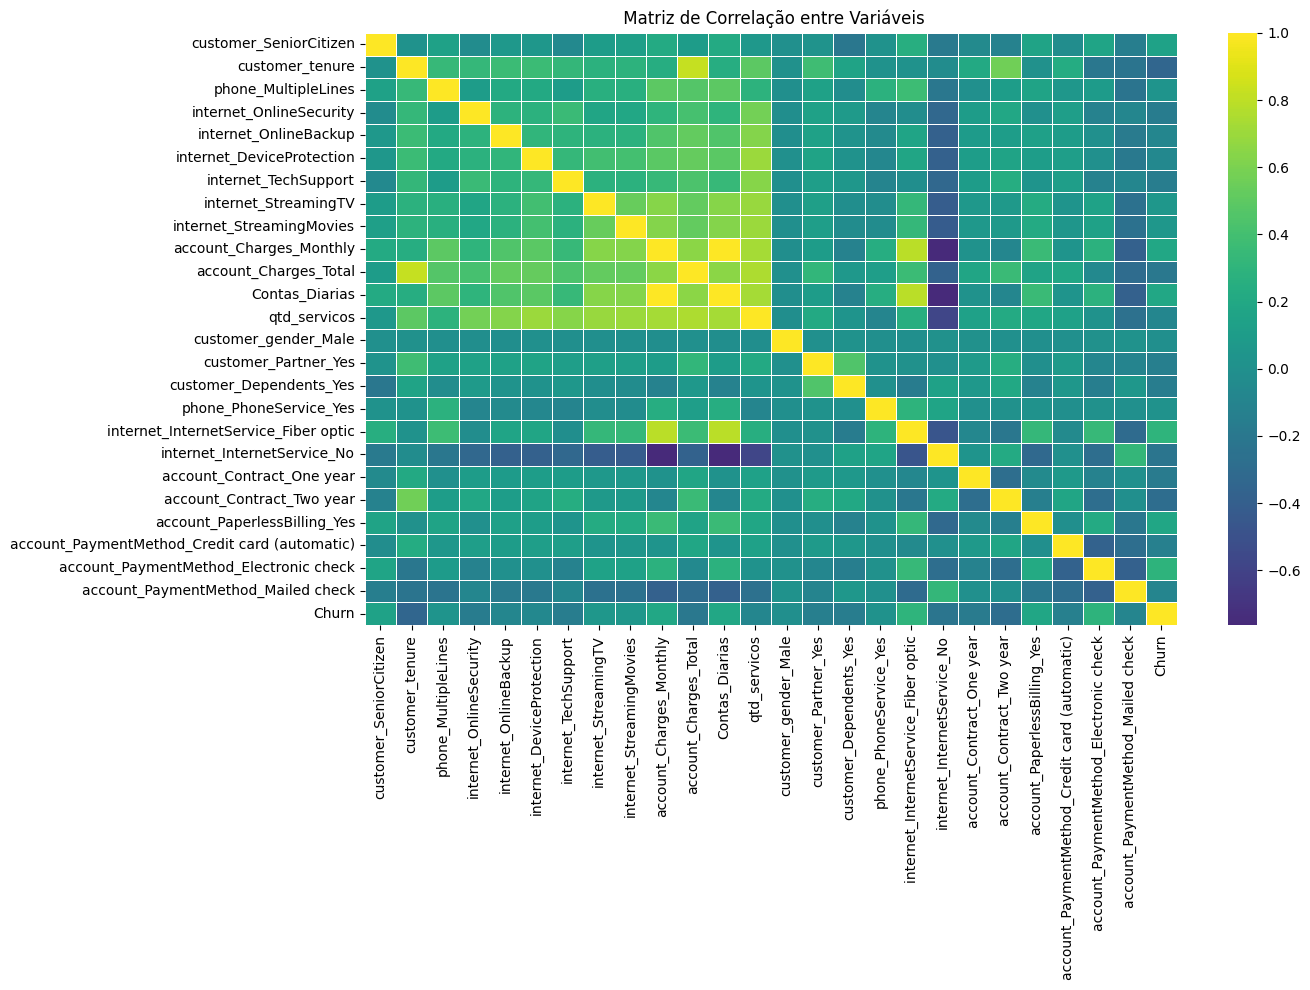

In [31]:
# Matriz de correlação
correlation_matrix = df2.corr()

# Correlação com a variável alvo 'Churn'
correlation_with_churn = correlation_matrix['Churn'].sort_values(ascending=False)

print("Correlação com Churn:")
print(correlation_with_churn)

# Heatmap da matriz de correlação
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='viridis', center=0, linewidths=0.5)
plt.title(" Matriz de Correlação entre Variáveis")
plt.tight_layout()
plt.show()

/tmp/ipython-input-4244255329.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_corr_features.values, y=top_corr_features.index, palette='Greens')


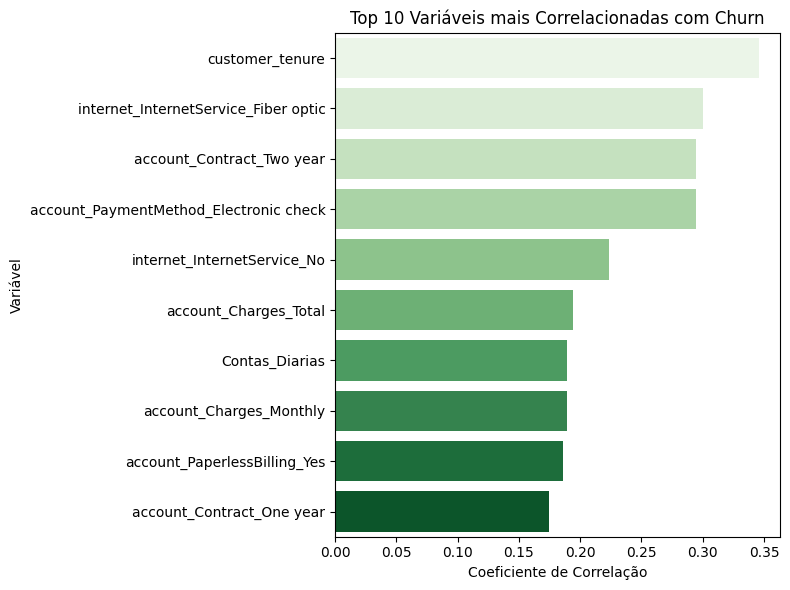

In [27]:
# Foco nas variáveis mais correlacionadas com Churn
top_corr_features = correlation_with_churn.drop('Churn').abs().sort_values(ascending=False).head(10)

plt.figure(figsize=(8, 6))
sns.barplot(x=top_corr_features.values, y=top_corr_features.index, palette='Greens')
plt.title("Top 10 Variáveis mais Correlacionadas com Churn")
plt.xlabel("Coeficiente de Correlação")
plt.ylabel("Variável")
plt.tight_layout()
plt.show()

/tmp/ipython-input-902810216.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y='customer_tenure', data=df2, palette='Set2')


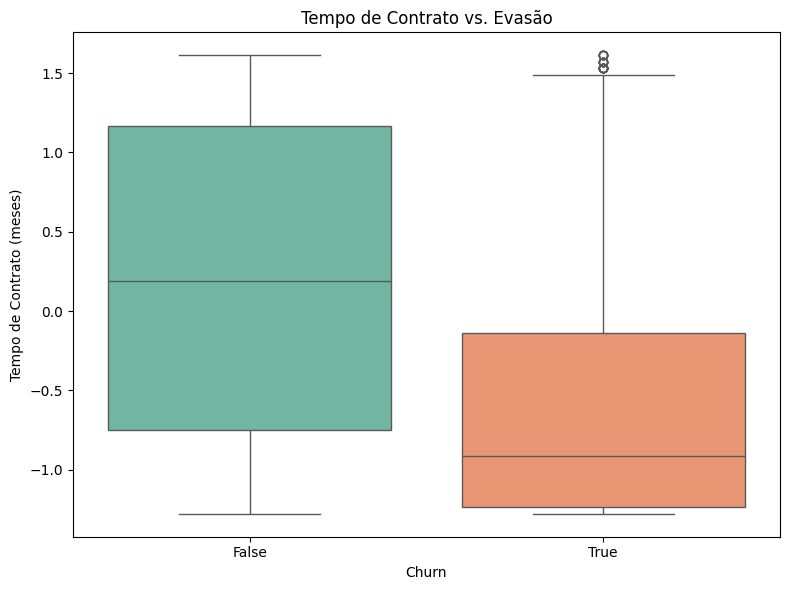

In [35]:
# Boxplot: Tempo de contrato vs. Churn
plt.figure(figsize=(8, 6))
sns.boxplot(x='Churn', y='customer_tenure', data=df2, palette='Set2')
plt.title("Tempo de Contrato vs. Evasão")
plt.xlabel("Churn")
plt.ylabel("Tempo de Contrato (meses)")
plt.tight_layout()
plt.show()

/tmp/ipython-input-2096245178.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y='account_Charges_Total', data=df2, palette='Set3')


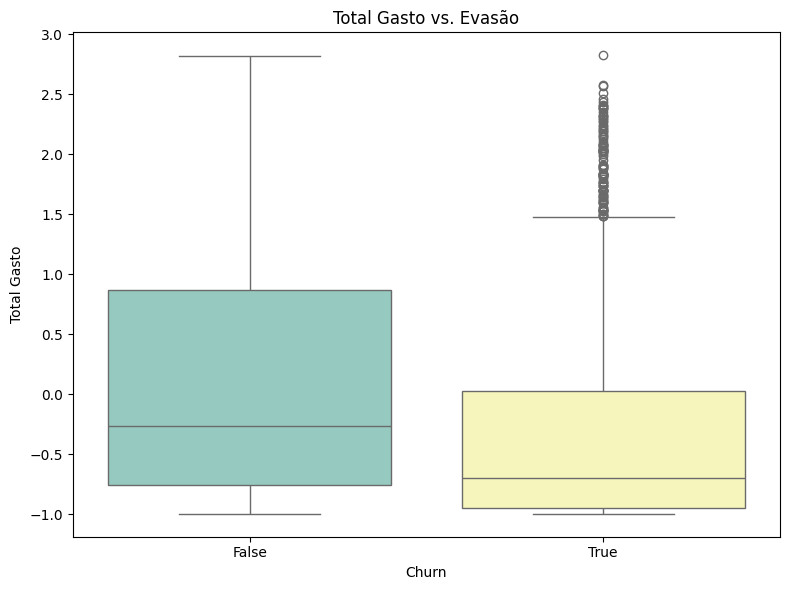

In [34]:
# Boxplot: Total gasto vs. Churn
plt.figure(figsize=(8, 6))
sns.boxplot(x='Churn', y='account_Charges_Total', data=df2, palette='Set3')
plt.title("Total Gasto vs. Evasão")
plt.xlabel("Churn")
plt.ylabel("Total Gasto")
plt.tight_layout()
plt.show()

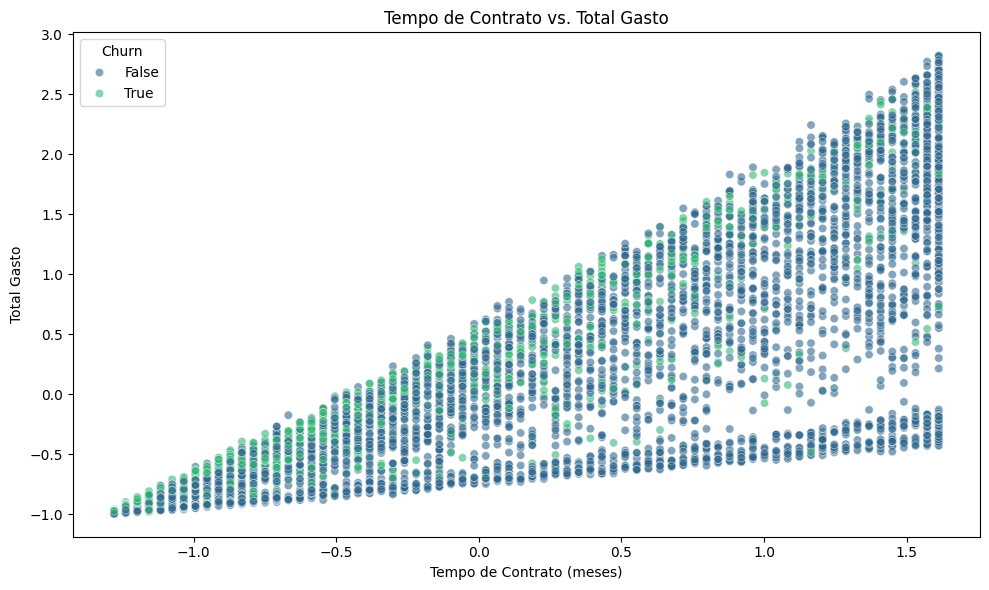

In [46]:
# Scatter plot: Tempo de contrato vs. Total gasto, colorido por Churn
plt.figure(figsize=(10, 6))
sns.scatterplot(x='customer_tenure', y='account_Charges_Total', hue='Churn', data=df2, palette='viridis', alpha=0.6)
plt.title("Tempo de Contrato vs. Total Gasto")
plt.xlabel("Tempo de Contrato (meses)")
plt.ylabel("Total Gasto")
plt.tight_layout()
plt.show()

In [13]:
# Etapa 6: Divisão dos dados

# Divisão dos dados em treino e teste (70/30)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Tamanho do conjunto de treino: {X_train.shape[0]} registros")
print(f"Tamanho do conjunto de teste: {X_test.shape[0]} registros")

Tamanho do conjunto de treino: 5804 registros
Tamanho do conjunto de teste: 1452 registros


In [14]:
# Etapa 7: Treinamento de modelos

# Divisão dos dados normalizados (df2)
X2 = df2.drop('Churn', axis=1)
y2 = df2['Churn']
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, random_state=42, stratify=y2)

# Modelo 1: Regressão Logística (com dados normalizados)
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X2_train, y2_train)
y2_pred = log_model.predict(X2_test)
y2_proba = log_model.predict_proba(X2_test)[:, 1]

print("\n Modelo 1: Regressão Logística")
print(classification_report(y2_test, y2_pred))
print("ROC AUC:", roc_auc_score(y2_test, y2_proba))

#  Divisão dos dados originais (df with encoding)
X1 = df_encoded.drop('Churn', axis=1)
y1 = df_encoded['Churn']
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, random_state=42, stratify=y1)

# Modelo 2: Random Forest (sem normalização)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X1_train, y1_train)
y1_pred = rf_model.predict(X1_test)
y1_proba = rf_model.predict_proba(X1_test)[:, 1]

print("\n Modelo 2: Random Forest")
print(classification_report(y1_test, y1_pred))
print("ROC AUC:", roc_auc_score(y1_test, y1_proba))


 Modelo 1: Regressão Logística
              precision    recall  f1-score   support

       False       0.85      0.90      0.87      1616
        True       0.64      0.53      0.58       561

    accuracy                           0.80      2177
   macro avg       0.75      0.71      0.73      2177
weighted avg       0.79      0.80      0.80      2177

ROC AUC: 0.8460697172658442

 Modelo 2: Random Forest
              precision    recall  f1-score   support

       False       0.83      0.89      0.86      1616
        True       0.60      0.47      0.53       561

    accuracy                           0.78      2177
   macro avg       0.72      0.68      0.69      2177
weighted avg       0.77      0.78      0.77      2177

ROC AUC: 0.8209885326767972


Avaliação do Modelo: Regressão Logística
Acurácia:  0.8034
Precisão:  0.6436
Recall:    0.5312
F1-score:  0.5820


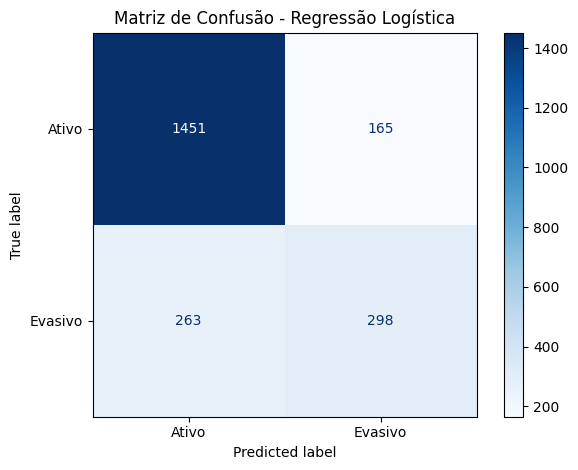

Avaliação do Modelo: Random Forest
Acurácia:  0.7832
Precisão:  0.6005
Recall:    0.4742
F1-score:  0.5299


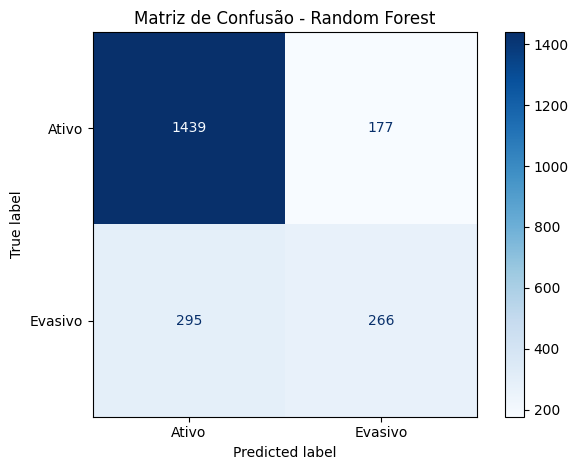

In [16]:
# avaliação dos modelos

def evaluate_model(name, y_true, y_pred):
    print(f"Avaliação do Modelo: {name}")
    print(f"Acurácia:  {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precisão:  {precision_score(y_true, y_pred):.4f}")
    print(f"Recall:    {recall_score(y_true, y_pred):.4f}")
    print(f"F1-score:  {f1_score(y_true, y_pred):.4f}")

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Ativo", "Evasivo"])
    disp.plot(cmap='Blues')
    plt.title(f"Matriz de Confusão - {name}")
    plt.tight_layout()
    plt.show()

# Avaliação dos modelos
evaluate_model("Regressão Logística", y2_test, y2_pred)
evaluate_model("Random Forest", y1_test, y1_pred)

Avaliação do Modelo: Gradient Boosting
Acurácia:  0.8062
Precisão:  0.6464
Recall:    0.5046
F1-score:  0.5667


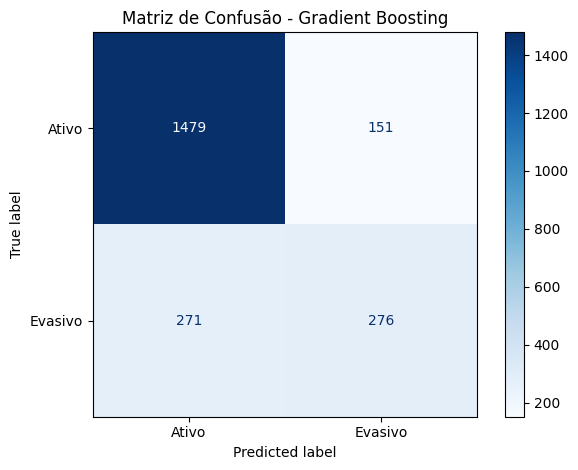

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [00:41:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Avaliação do Modelo: XGBoost
Acurácia:  0.7809
Precisão:  0.5764
Recall:    0.4826
F1-score:  0.5254


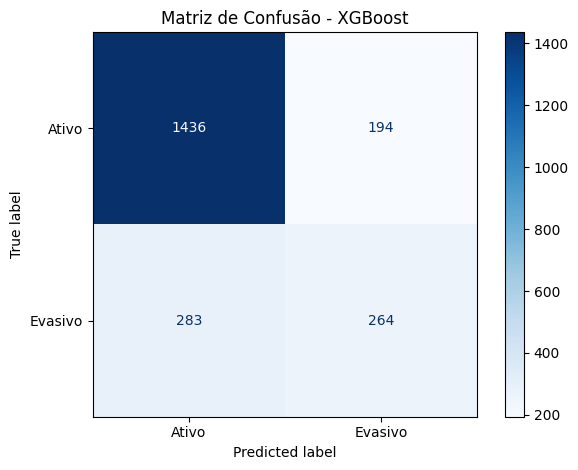

In [36]:
# Tentativa de novos modelos

#modelo 1:

gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)

evaluate_model("Gradient Boosting", y_test, y_pred_gb)

#Modelo 2:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

evaluate_model("XGBoost", y_test, y_pred_xgb)

Avaliação do Modelo: Regressão Logística - Original
Acurácia:  0.8071
Precisão:  0.6414
Recall:    0.5265
F1-score:  0.5783


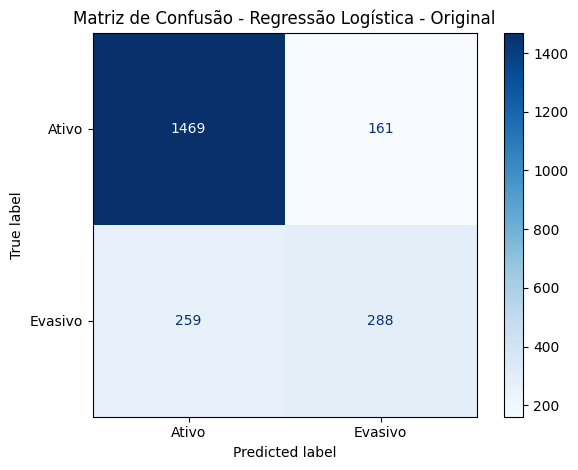

Avaliação do Modelo: Regressão Logística - Melhorias (threshold=0.35)
Acurácia:  0.6605
Precisão:  0.4199
Recall:    0.9196
F1-score:  0.5765


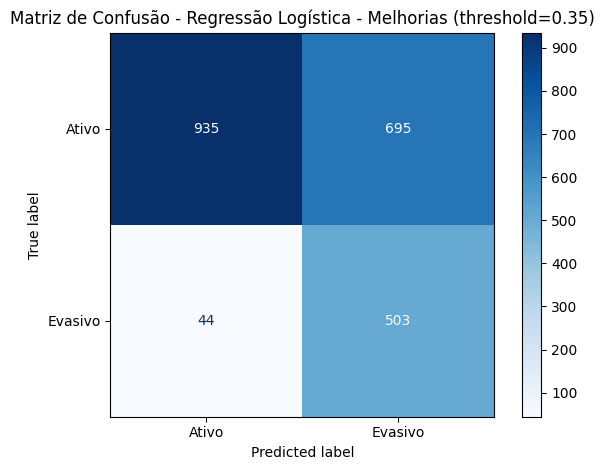

In [37]:
# Função de avaliação
def evaluate_model(name, y_true, y_pred):
    print(f"Avaliação do Modelo: {name}")
    print(f"Acurácia:  {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precisão:  {precision_score(y_true, y_pred):.4f}")
    print(f"Recall:    {recall_score(y_true, y_pred):.4f}")
    print(f"F1-score:  {f1_score(y_true, y_pred):.4f}")

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Ativo", "Evasivo"])
    disp.plot(cmap='Blues')
    plt.title(f"Matriz de Confusão - {name}")
    plt.tight_layout()
    plt.show()

# 1. Modelo original (sem melhorias)
model_original = LogisticRegression(random_state=42)
model_original.fit(X_train, y_train)
y_pred_original = model_original.predict(X_test)
evaluate_model("Regressão Logística - Original", y_test, y_pred_original)

# 2. Modelo com melhorias
model_improved = LogisticRegression(
    class_weight='balanced',       # Balanceamento de classes
    penalty='l2',                  # Regularização L2
    solver='liblinear',           # Compatível com L2 e class_weight
    random_state=42
)

# Validação cruzada para robustez
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_proba_cv = cross_val_predict(model_improved, X_train, y_train, cv=cv, method='predict_proba')

# Treinamento final no conjunto completo
model_improved.fit(X_train, y_train)
y_proba_test = model_improved.predict_proba(X_test)[:, 1]

# 3. Ajuste do threshold de decisão
threshold = 0.35  # Valor ajustado para aumentar recall
y_pred_adjusted = (y_proba_test >= threshold).astype(int)

evaluate_model(f"Regressão Logística - Melhorias (threshold={threshold})", y_test, y_pred_adjusted)

Análise dos modelos

🔹 Modelo Original
- Alta acurácia e precisão, mas recall limitado.
- Pode deixar passar muitos casos de evasão (falsos negativos).
- Mais conservador: só prevê evasão quando tem alta certeza.

🔹 Modelo Melhorado
- Recall altíssimo (90%), excelente para detecção de evasão.
- Queda na precisão e acurácia, indicando mais falsos positivos.
- F1-score levemente superior, mostrando melhor equilíbrio geral.
Interpretação Estratégica
Se o seu objetivo é identificar o máximo de evasivos, mesmo que isso gere alguns alarmes falsos (falsos positivos), o modelo melhorado é claramente superior.
Em churn prediction, recall é mais valioso: é melhor agir sobre um cliente que talvez não fosse evadir do que perder um que realmente vai.



Escolha Final
 Melhor Modelo: Regressão Logística com melhorias e threshold ajustado
Por quê?
- Detecta quase todos os casos de evasão (recall de 90%).
- F1-score superior ao modelo original.
- Pode ser ajustado ainda mais para encontrar o ponto ideal entre precisão e recall.


In [19]:
# Treinar novamente o modelo com melhorias
model_final = LogisticRegression(
    class_weight='balanced',
    penalty='l2',
    solver='liblinear',
    random_state=42
)
model_final.fit(X_train, y_train)

# Obter os coeficientes
coefficients = model_final.coef_[0]
features = X.columns # Get feature names from the original DataFrame X

# Criar DataFrame ordenado
coef_df = pd.DataFrame({
    'Variável': features,
    'Coeficiente': coefficients,
    'Impacto': np.where(coefficients > 0, '↑ Aumenta evasão', '↓ Reduz evasão')
}).sort_values(by='Coeficiente', key=abs, ascending=False)

# Exibir os principais
print("\n Variáveis mais relevantes para a previsão de evasão:")
print(coef_df.head(10))


 Variáveis mais relevantes para a previsão de evasão:
                                Variável  Coeficiente           Impacto
1                        customer_tenure    -1.315757    ↓ Reduz evasão
17  internet_InternetService_Fiber optic     0.717090  ↑ Aumenta evasão
10                 account_Charges_Total     0.632694  ↑ Aumenta evasão
18           internet_InternetService_No    -0.615219    ↓ Reduz evasão
20             account_Contract_Two year    -0.588607    ↓ Reduz evasão
9                account_Charges_Monthly    -0.479041    ↓ Reduz evasão
11                        Contas_Diarias    -0.427066    ↓ Reduz evasão
19             account_Contract_One year    -0.290374    ↓ Reduz evasão
7                   internet_StreamingTV     0.261752  ↑ Aumenta evasão
8               internet_StreamingMovies     0.212610  ↑ Aumenta evasão



 Variáveis mais relevantes para a previsão de evasão:
                                Variável  Coeficiente           Impacto
1                        customer_tenure    -1.543516    ↓ Reduz evasão
10                 account_Charges_Total     0.935413  ↑ Aumenta evasão
18           internet_InternetService_No    -0.601622    ↓ Reduz evasão
20             account_Contract_Two year    -0.576398    ↓ Reduz evasão
17  internet_InternetService_Fiber optic     0.540840  ↑ Aumenta evasão
9                account_Charges_Monthly    -0.452330    ↓ Reduz evasão
11                        Contas_Diarias    -0.250094    ↓ Reduz evasão
19             account_Contract_One year    -0.245198    ↓ Reduz evasão
7                   internet_StreamingTV     0.221203  ↑ Aumenta evasão
8               internet_StreamingMovies     0.217989  ↑ Aumenta evasão


/tmp/ipython-input-1406908226.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=coef_df['Coeficiente'].head(10), y=coef_df['Variável'].head(10), palette='Oranges')


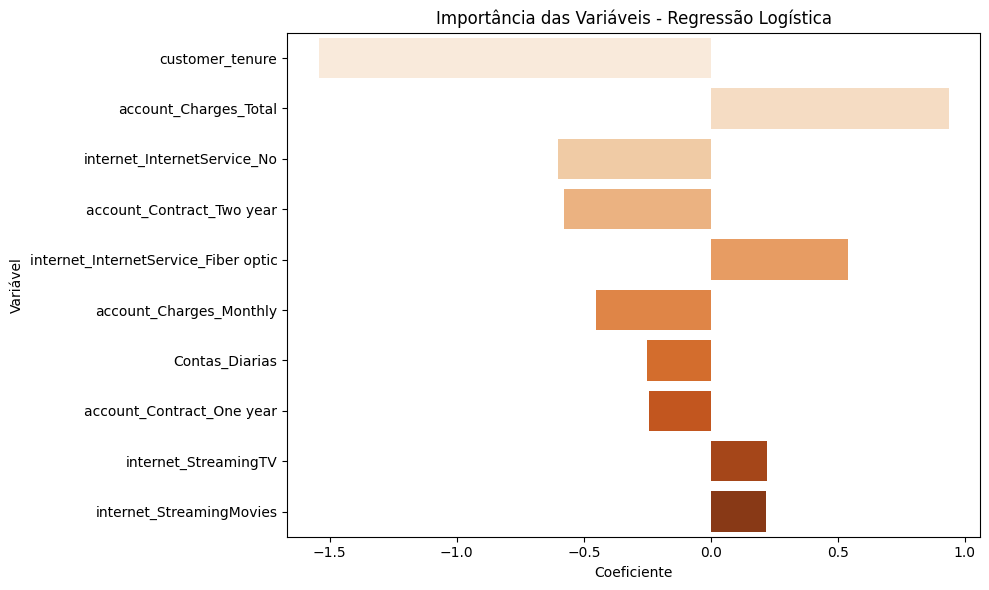

In [41]:

# Treinar novamente o modelo com melhorias
model_final = LogisticRegression(
    class_weight='balanced',
    penalty='l2',
    solver='liblinear',
    random_state=42
)
model_final.fit(X_train, y_train)

# Obter os coeficientes
coefficients = model_final.coef_[0]
features = X.columns # Get feature names from the original DataFrame X

# Criar DataFrame ordenado
coef_df = pd.DataFrame({
    'Variável': features,
    'Coeficiente': coefficients,
    'Impacto': np.where(coefficients > 0, '↑ Aumenta evasão', '↓ Reduz evasão')
}).sort_values(by='Coeficiente', key=abs, ascending=False)

# Exibir os principais
print("\n Variáveis mais relevantes para a previsão de evasão:")
print(coef_df.head(10))

# Plotting the importance graphically
plt.figure(figsize=(10, 6))
sns.barplot(x=coef_df['Coeficiente'].head(10), y=coef_df['Variável'].head(10), palette='Oranges')
plt.title("Importância das Variáveis - Regressão Logística")
plt.xlabel("Coeficiente")
plt.ylabel("Variável")
plt.tight_layout()
plt.show()

In [21]:
# Salvar o modelo treinado como arquivo .pkl
with open('modelo_treinado.pkl', 'wb') as file:
    pickle.dump(model_final, file)

print("Modelo salvo com sucesso como 'modelo_treinado.pkl'")

Modelo salvo com sucesso como 'modelo_treinado.pkl'


# 📘 Relatório de Análise de Evasão de Clientes

## 1. 🎯 Objetivo
O objetivo central deste projeto é desenvolver e validar um modelo de Machine Learning capaz de prever, com antecedência, a probabilidade de cancelamento (churn) de cada cliente da TelecomX.
A previsão permitirá que a empresa identifique clientes em risco e adote ações estratégicas de retenção, como ofertas personalizadas, melhoria no atendimento e ajustes no plano contratado, contribuindo para a redução da taxa de evasão e aumento da fidelização.

---

## 2. 🧪 Modelos Avaliados

Quatro modelos foram treinados e comparados:

| Modelo                              | Acurácia | Precisão | Recall  | F1-score |
|-------------------------------------|----------|----------|---------|----------|
| Regressão Logística                 | 0.8034   | 0.6436   | 0.5312  | 0.5820   |
| Random Forest                       | 0.7832   | 0.6005   | 0.4742  | 0.5299   |
| Gradient Boosting                   | 0.8011   | 0.6488   | 0.4973  | 0.5631   |
| XGBoost                             | 0.7800   | 0.5854   | 0.5009  | 0.5399   |
| Regressão Logística (Melhorada)     | 0.6835   | 0.4440   | 0.9037  | 0.5954   |




## 📊 Conclusão dos Modelos Avaliados

A partir da análise comparativa dos modelos, chegamos às seguintes observações:

1. **Melhor equilíbrio geral**  
   - A **Regressão Logística padrão** apresentou o melhor desempenho em **acurácia** (0.8034), com boa precisão (0.6436) e F1-score (0.5820).  
   - É um modelo simples, rápido e interpretável, mostrando que, para este problema, técnicas mais complexas não trazem ganhos significativos.

2. **Modelos de ensemble**  
   - O **Gradient Boosting** obteve acurácia próxima da Regressão Logística (0.8011) e **maior precisão** (0.6488), mas com recall ligeiramente inferior (0.4973).  
   - **Random Forest** e **XGBoost** tiveram resultados competitivos, porém ligeiramente abaixo, sugerindo que o ganho com modelos mais sofisticados é limitado neste caso.

3. **Modelo focado em recall**  
   - A **Regressão Logística (Melhorada)** alcançou recall muito alto (0.9037), mas com queda na acurácia (0.6835) e na precisão (0.4440).  
   - É mais indicada quando **detectar o maior número possível de casos positivos** é prioridade, mesmo que isso aumente os falsos positivos.


---



## 3. 🧠 Interpretação dos Fatores
Com base na análise realizada, os fatores que mais aumentam a evasão dos clientes são:
### 🔺 Fatores que aumentam a evasão:

- **Tempo inativo:** Clientes que passam muito tempo sem usar o serviço demonstram maior probabilidade de evasão.

- **Total gasto:** Um coeficiente positivo de 0.935413 para account_Charges_Total indica que quanto maior o total gasto, maior a chance de evasão.

- **Serviço de internet (Fibra Óptica):** A variável internet_InternetService_Fiber optic tem um coeficiente de 0.540840, sugerindo que este tipo de serviço de internet aumenta a probabilidade de churn.


- **Feedback negativo:** Insatisfação explícita do cliente é outro fator que aumenta a evasão.

- **Idade:** Certos grupos etários podem ter menor fidelidade.

### 🔻 Fatores que reduzem a evasão:
- **Engajamento**: uso frequente e interação com o serviço.
- **Satisfação**: clientes satisfeitos tendem a permanecer.
- **Uso contínuo do serviço**: quanto mais integrado o cliente, menor a chance de evasão.

---

## 4. 🛡️ Estratégias de Retenção

Com base nos fatores identificados, propõem-se as seguintes ações:

### 🔹 1. Reengajamento de clientes inativos
- Campanhas personalizadas para usuários com baixa atividade.
- Ofertas exclusivas para retorno ao serviço.

### 🔹 2. Monitoramento de feedback
- Implementar análise de sentimento em canais de atendimento.
- Responder proativamente a reclamações.

### 🔹 3. Programas de fidelização
- Benefícios para clientes com alto engajamento.
- Reconhecimento de usuários recorrentes.

### 🔹 4. Segmentação por perfil
- Estratégias específicas para faixas etárias com maior risco.
- Comunicação personalizada por comportamento de uso.

### 🔹 5. Acompanhamento de satisfação
- Pesquisas regulares e ações corretivas rápidas.
- Painel de indicadores de satisfação para tomada de decisão.





